In [124]:
# import modules
import sys
from os import listdir, path
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xarray as xr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [126]:
# constnats
AREA_WIDTH  = 17000
AREA_HIGHT = 3500

BLOCK_WIDTH  = 400
BLOCK_HEIGHT = 100

NUMBER_OF_SAMPLE = 301#401
NUMBER_OF_RECEIVERS = 341#401

Nx = 341
Ny = 351

dx = AREA_WIDTH / (Nx-1)
dy = AREA_HIGHT / (Ny-1)

print(f'Grid steps dx : {dx}, dy : {dy}')
nx, ny = int(BLOCK_WIDTH/dx), int(BLOCK_HEIGHT/dy)
print(f'Block size in nodes : ({nx}, {ny})')

Grid steps dx : 50.0, dy : 10.0
Block size in nodes : (8, 10)


# Prepare dataset

In [127]:
## read empty signal
import struct

X_empty = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
with open('seismogram_clean.bin', 'rb') as fd :
    for i in range(NUMBER_OF_SAMPLE):
        ts = struct.unpack('d', fd.read(8))
        tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
        if(tmp.size == 0):
            break
        X_empty[0, i, :] = tmp[::2] #vx
        X_empty[1, i, :] = tmp[1::2] #vy

In [128]:
import struct

dir = "./dataset_mixed/vtk/"
# seismograms
X = {}
# target boxes
y = {}
# scalars
y_s = {}

x_p = np.arange(Nx, dtype='int')
y_p = np.arange(Ny, dtype='int')

X_p, Y_p = np.meshgrid(x_p, y_p)

mask = np.zeros((Ny, Nx), dtype='bool')

# read signals
for file in listdir(dir):
    with open(dir+file, 'rb') as fd :
        str = file.split('_')
        x0 = int(int(str[1])/dx)
        y0 = int(int(str[2])/dy)
        y_sc = float(int(str[3][:str[3].find('.')]))

        signal = np.zeros(shape=(2, NUMBER_OF_SAMPLE, NUMBER_OF_RECEIVERS), dtype=np.float64)
        for i in range(NUMBER_OF_SAMPLE):
            ts = struct.unpack('d', fd.read(8))
            tmp = np.frombuffer(fd.read(8 * NUMBER_OF_RECEIVERS * 2), dtype=np.float64)
            if(tmp.size == 0):
                break
            signal[0, i, :] = tmp[::2] - X_empty[0, i, :]#vx
            signal[1, i, :] = tmp[1::2] - X_empty[1, i, :]#vy

        key = (x0, y0)

        dist = np.abs(X_p - \
                      ( (X_p < x0) * x0 + (X_p > (x0+nx)) * (x0+nx) + (X_p >= x0) * (X_p <= (x0+nx)) * X_p  )  )/ (5*nx) \
                      + np.abs(Y_p - \
                      ( (Y_p < y0) * y0 + (Y_p > (y0+ny)) * (y0+ny) + (Y_p >= y0) * (Y_p <= (y0+ny)) * Y_p  ) ) / (5*ny)

        tmp = np.exp(-dist)+ 15 / np.sqrt(Nx*Ny)

        if (key in X.keys()):
            X[key].append(signal)
            y[key].append(np.copy(mask))
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key].append(y_sc)

        else:
            X[key] = [signal]
            y[key] = [np.copy(mask)]
            y[key][-1][y0:(y0+ny), x0:(x0+nx)] = 1
            y_s[key] = [y_sc]

In [129]:
# train.test split
import random
from copy import deepcopy
from random import shuffle
from random import sample

test_size = 0.2
batch_size = 32

keys = list(X.keys())
random.shuffle(keys)
ind_split = int(len(keys) * test_size)

test_keys = keys[0:ind_split]
train_keys = keys[ind_split:-1]

X_test, y_test, y_s_test = [], [], []

test_dict_x = {}
test_dict_y_s = {}
for key in test_keys:
    ind = [i for i in range(len(X[key]))]
    shuffle(ind)
    test_dict_x[key] = [X[key][i] for i in ind]
    test_dict_y_s[key] = [y_s[key][i] for i in ind]

x0_test = []
y0_test = []

while test_dict_x.keys():
    if batch_size < len(test_dict_x.keys()):
        selected_keys = random.sample(test_dict_x.keys(), batch_size)
    else:
        selected_keys = test_dict_x.keys()
    for key in deepcopy(list(selected_keys)):
        X_test.append(test_dict_x[key].pop())
        y_test.append(y[key][0])
        y_s_test.append(test_dict_y_s[key].pop())
        x0_test.append(int(key[0] * dx))
        y0_test.append(int(key[1] * dy))
        if len(test_dict_x[key]) == 0 :
            test_dict_x.pop(key, None)
            test_dict_y_s.pop(key, None)

X_train, y_train, y_s_train = [], [], []

train_dict_x = {}
train_dict_y_s = {}
for key in train_keys:
    ind = [i for i in range(len(X[key]))]
    shuffle(ind)
    train_dict_x[key] = [X[key][i] for i in ind]
    train_dict_y_s[key] = [y_s[key][i] for i in ind]

while train_dict_x.keys():
    if batch_size < len(train_dict_x.keys()):
        selected_keys = random.sample(train_dict_x.keys(), batch_size)
    else:
        selected_keys = train_dict_x.keys()
    for key in deepcopy(list(selected_keys)):
        X_train.append(train_dict_x[key].pop())
        y_train.append(y[key][0])
        y_s_train.append(train_dict_y_s[key].pop())
        if len(train_dict_x[key]) == 0 :
            train_dict_x.pop(key, None)
            train_dict_y_s.pop(key, None)


In [9]:
from torchvision.transforms import Resize

resize = Resize((Ny, Nx))

class SeismicDataset(Dataset):
    def __init__(self, X, y, y_s, transform=resize):
        self.transform=transform
        self.X = deepcopy(X)
        self.y = deepcopy(y)
        self.y_s = deepcopy(y_s)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_out = torch.tensor(self.X[idx].copy())
        return  self.transform(X_out), torch.tensor(self.y[idx].copy()), torch.tensor(self.y_s[idx])

train_dataset = SeismicDataset(X_train, y_train, y_s_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = SeismicDataset(X_test, y_test, y_s_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

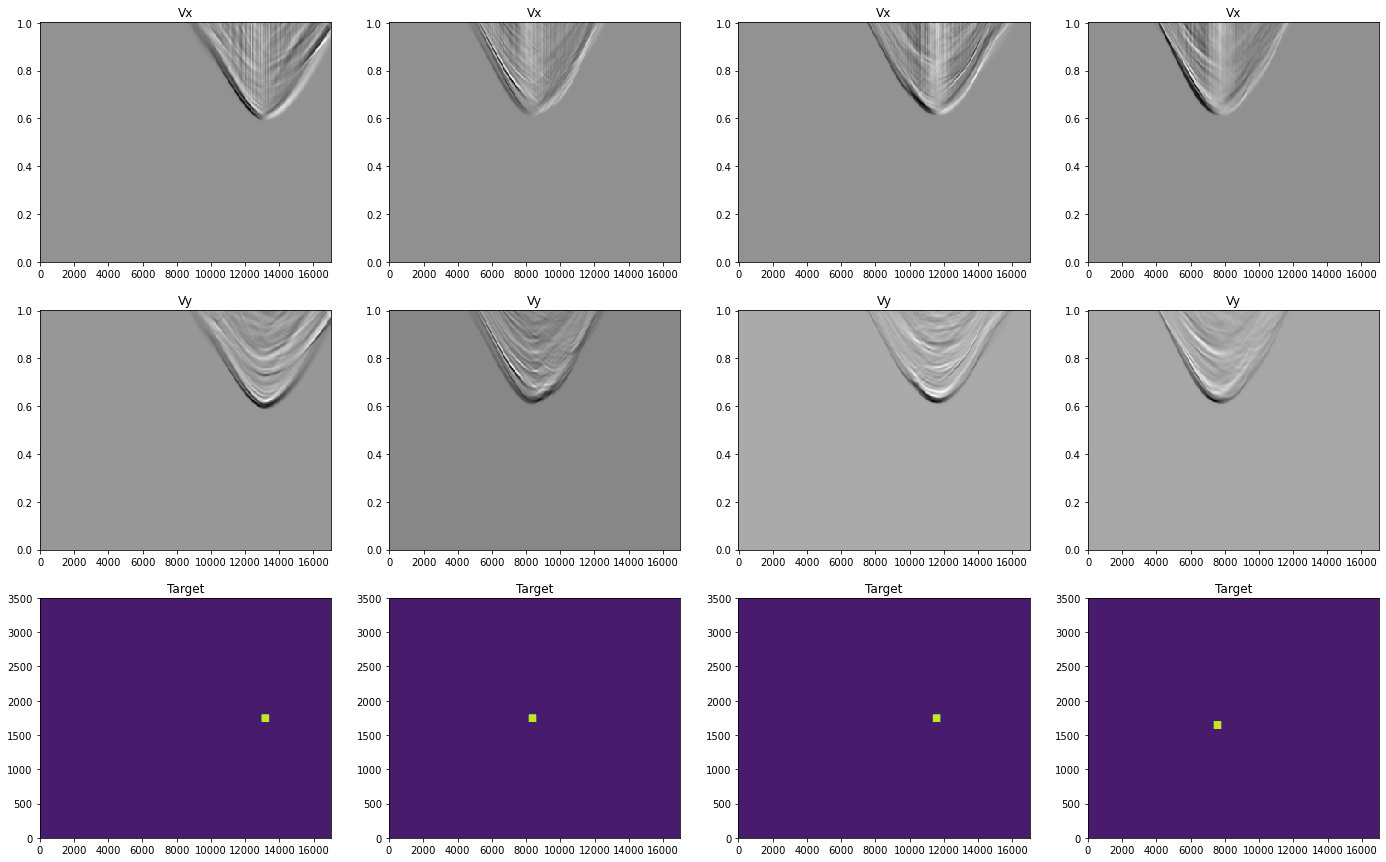

In [10]:
from matplotlib.pyplot import cm

X_1, y_1, y_s_1 = next(iter(train_dataloader))

x = np.linspace(0, AREA_WIDTH, Nx)
t = np.linspace(0, 1, Ny)

fig, ax = plt.subplots(3, 4, figsize = (24, 15))

for i in range(4):
    ax[0, i].pcolormesh(x, t, X_1[i, 0, :], cmap=cm.gray)
    ax[0, i].set_title('Vx')
    ax[1, i].pcolormesh(x, t, X_1[i, 1, :], cmap=cm.gray)
    ax[1, i].set_title('Vy')
    ax[2, i].set_title('Target')
    ax[2, i].contourf(x, t*AREA_HIGHT, y_1[i, :])

plt.show()

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single-traget detection

In [45]:
from models import UNet
from torch.nn import BCEWithLogitsLoss
from metrics import Precision, Recall, DiceScore
from train import train_detection

weight_bce = torch.tensor(AREA_WIDTH / BLOCK_WIDTH)
print(weight_bce)
model = UNet(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = BCEWithLogitsLoss(pos_weight=weight_bce)
metric_dict = {
    'Precision' : Precision,
    'DiceScore' : DiceScore,
    'Recall' : Recall
}

tensor(42.5000)


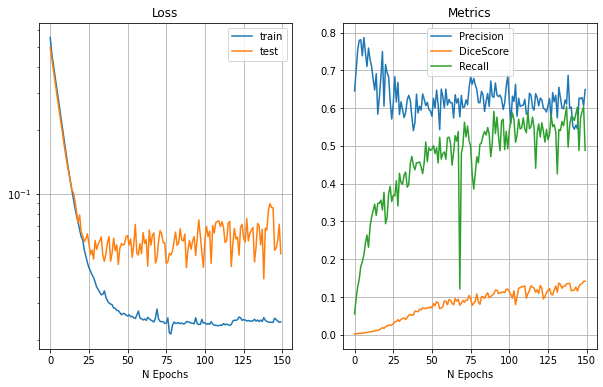

Loss on validation : 0.05167860922433978 

Precision : 0.6491374539253406  

DiceScore : 0.14184089949854034  

Recall : 0.48850116514621816  



In [46]:
model, lm = train_detection(model, optimizer, train_dataloader, test_dataloader,
                            len(train_dataset), len(test_dataset),
                            Loss, metric_dict, N_epochs = 150)

In [56]:
# find corellation with x0 and y0 position
prec = []
recall = []
dice = []

for X, y, _ in test_dataloader:
    X = X.float()
    y = y.squeeze()
    y_pred = model(X.to(device)).squeeze().to('cpu')
    y_pred = y_pred.float()
    
    for i in range(y_pred.shape[0]):
        prec.append(Precision(y[i, :].unsqueeze(0), torch.sigmoid(y_pred[i, :]).unsqueeze(0)).item())
        recall.append(Recall(y[i, :].unsqueeze(0), torch.sigmoid(y_pred[i, :]).unsqueeze(0)).item())
        dice.append(DiceScore(y[i, :].unsqueeze(0), torch.sigmoid(y_pred[i, :]).unsqueeze(0)).item())

In [58]:
len(x0_test)

798

In [59]:
print(f'Corellation with x0 \n'
      f'Precision : {np.corrcoef(prec, x0_test)[1, 0]}\n'
      f'Recall : {np.corrcoef(recall, x0_test)[1, 0]}\n'
      f'Dice : {np.corrcoef(dice, x0_test)[1, 0]}')

print(f'Corellation with y0 \n'
      f'Precision : {np.corrcoef(prec, y0_test)[1, 0]}\n'
      f'Recall : {np.corrcoef(recall, y0_test)[1, 0]}\n'
      f'Dice : {np.corrcoef(dice, y0_test)[1, 0]}')

Corellation with x0 
Precision : 0.13287797312737148
Recall : 0.23830939297881473
Dice : 0.046285964891706693
Corellation with y0 
Precision : -0.4167267732843438
Recall : -0.33206287705874904
Dice : -0.4725803111502597


In [87]:
dict_x0 = {}
dict_y0 = {}

for x0, p, r, d in zip(x0_test, prec, recall, dice):
    if x0 not in dict_x0.keys():
        dict_x0[x0] = (p, r, d, 1)
        
    else:
        N = dict_x0[x0][3]
        dict_x0[x0] = ( (dict_x0[x0][0] * N + p) / (N+1), 
                        (dict_x0[x0][1] * N + r) / (N+1),
                        (dict_x0[x0][2] * N + d) / (N+1),
                        N + 1)
        
for y0, p, r, d in zip(y0_test, prec, recall, dice):
    if y0 not in dict_y0.keys():
        dict_y0[y0] = (p, r, d, 1)
    else:
        N = dict_y0[y0][3]
        dict_y0[y0] = ( (dict_y0[y0][0] * N + p) / (N+1), 
                        (dict_y0[y0][1] * N + r) / (N+1),
                        (dict_y0[y0][2] * N + d) / (N+1),
                        N + 1)

In [88]:
x0_list = []
prec_x = []
rec_x = []
dice_x = []

for key, value in dict_x0.items():
    x0_list.append(key)
    prec_x.append(value[0])
    rec_x.append(value[1])
    dice_x.append(value[2])
    
ind = np.argsort(x0_list)
x0_list = np.array(x0_list)[ind]
prec_x = np.array(prec_x)[ind]
rec_x = np.array(rec_x)[ind]
dice_x = np.array(dice_x)[ind]

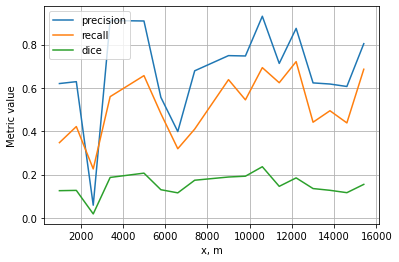

In [89]:
plt.plot(x0_list, prec_x, label='precision')
plt.plot(x0_list, rec_x, label='recall')
plt.plot(x0_list, dice_x, label='dice')
plt.xlabel('x, m')
plt.ylabel('Metric value')
plt.grid()
plt.legend()
plt.show()

In [90]:
y0_list = []
prec_y = []
rec_y = []
dice_y = []

for key, value in dict_y0.items():
    y0_list.append(key)
    prec_y.append(value[0])
    rec_y.append(value[1])
    dice_y.append(value[2])
    
ind = np.argsort(y0_list)
y0_list = np.array(y0_list)[ind]
prec_y = np.array(prec_y)[ind]
rec_y = np.array(rec_y)[ind]
dice_y = np.array(dice_y)[ind]

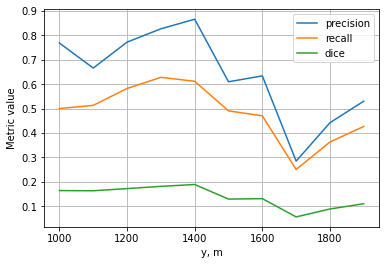

In [91]:
plt.plot(y0_list, prec_y, label='precision')
plt.plot(y0_list, rec_y, label='recall')
plt.plot(y0_list, dice_y, label='dice')
plt.xlabel('y, m')
plt.ylabel('Metric value')
plt.grid()
plt.legend()
plt.show()

# Single-traget regression

In [116]:
from models import CNN_st
from train import train_regression
from sklearn.metrics import r2_score

model = CNN_st(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss = nn.MSELoss()
metric_dict = {'R2 score' : r2_score}

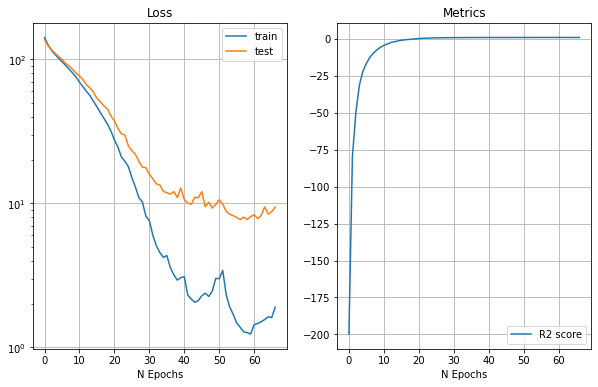

Loss on validation : 9.406396079481693 

R2 score : 0.9266682731542669  



KeyboardInterrupt: 

In [117]:
model, lm = train_regression(model, optimizer, train_dataloader, test_dataloader,
                            len(train_dataset), len(test_dataset),
                            Loss, metric_dict, N_epochs = 100)

In [130]:
y_pred_val = torch.tensor([0])
y_true_val = torch.tensor([0])

with torch.no_grad():
        for X, _, y in test_dataloader:
            X = X.float()
            y_pred = model(X.to(device)).squeeze().to('cpu')
            
            if torch.numel(y_pred) > 1:
                y_pred_val = torch.cat((y_pred_val, y_pred), dim=0)
                y_true_val = torch.cat((y_true_val, y.to('cpu')), dim=0)

y_pred_val = y_pred_val[1::]
y_true_val = y_true_val[1::]

positions_test = np.unique(np.array(y_test), axis= 0)
x_0 = []
y_0 = []

for position in positions_test:
    x_0.append(np.argwhere(position)[:, 0].min() * dx)
    y_0.append(np.argwhere(position)[:, 1].min() * dy)
ind = np.argsort(y_0)
x_0 = np.array(x_0)[ind]
y_0 = np.array(y_0)[ind]
positions_test = positions_test[ind]

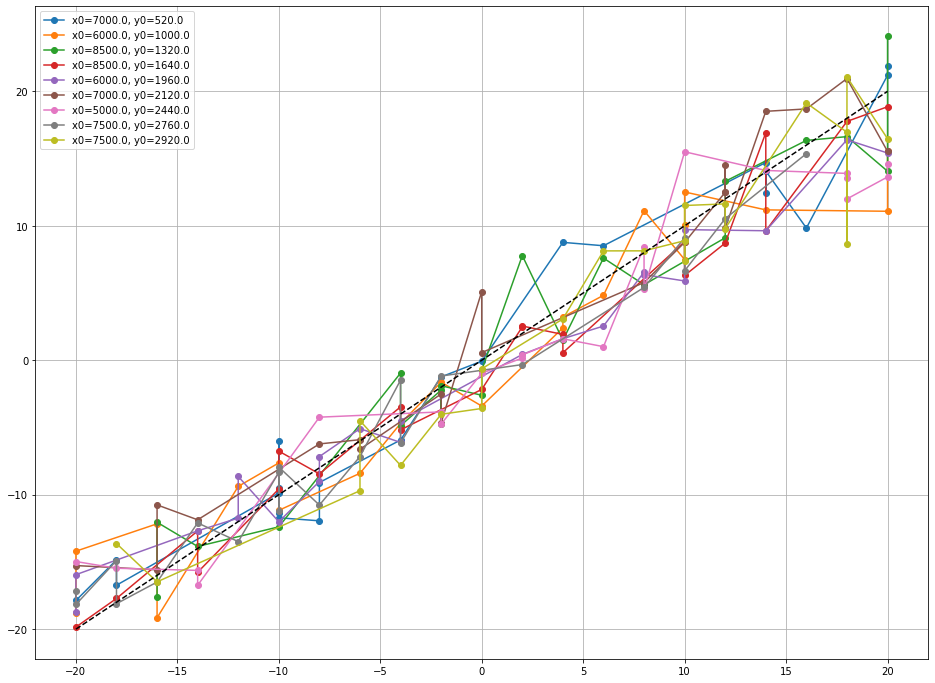

In [135]:
fig, ax = plt.subplots(figsize = (16, 12))

for position, x0, y0 in zip(positions_test[3::4], x_0[3::4], y_0[3::4]):
    filter = np.sum(np.abs(1 * y_test- 1* position), axis = (1, 2)) == 0
    ind_sort = np.argsort(y_true_val[filter])
    x1 = y_true_val[filter][ind_sort]
    y1 = y_pred_val[filter][ind_sort]
    
    plt.plot(x1, y1, marker='o', label=f'x0={x0}, y0={y0}')

plt.plot([-20, 20], [-20, 20], linestyle='--', color='k')
plt.grid()
plt.legend()
plt.show()

In [136]:
# find corellation with x0 and y0 position
mse = []

for X, _, y in test_dataloader:
    X = X.float()
    y = y.squeeze()
    y_pred = model(X.to(device)).squeeze().to('cpu')
    y_pred = y_pred.float()
    
    for i in range(y_pred.shape[0]):
        mse.append( torch.sqrt((y[i]- y_pred[i]) ** 2).item())

In [137]:
print(f'Corellation with x0 \n'
      f'Precision : {np.corrcoef(mse, x0_test)[1, 0]}')

print(f'Corellation with y0 \n'
      f'Precision : {np.corrcoef(mse, y0_test)[1, 0]}')

Corellation with x0 
Precision : 0.09784488156170959
Corellation with y0 
Precision : -0.04617381525311913


# Cross Stitch-Network

In [146]:
from models import U_net_cat
from train import train_multitask
from metrics import Precision, Recall, DiceScore
from sklearn.metrics import r2_score

from train import Loss_Metrics_Mem

model = U_net_cat(in_channels = 2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
Loss1 = torch.nn.BCEWithLogitsLoss()
Loss2 = torch.nn.MSELoss()
metric_dict1 = {
    'Precision' : Precision,
    'DiceScore' : DiceScore,
    'Recall' : Recall
}
metric_dict2 = {'R2 score' : r2_score}

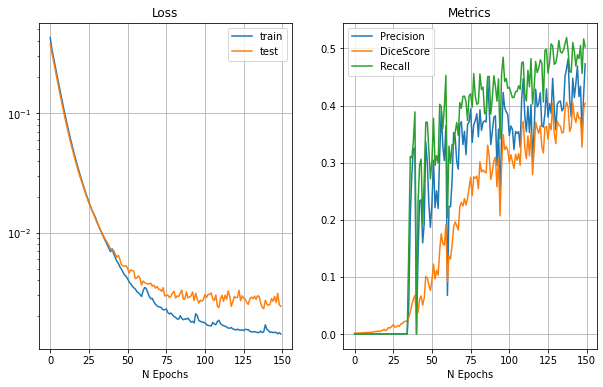

Loss on validation : 0.0024265272164703307 

Precision : 0.4731135165183466  

DiceScore : 0.4042670684948302  

Recall : 0.5025790604134848  



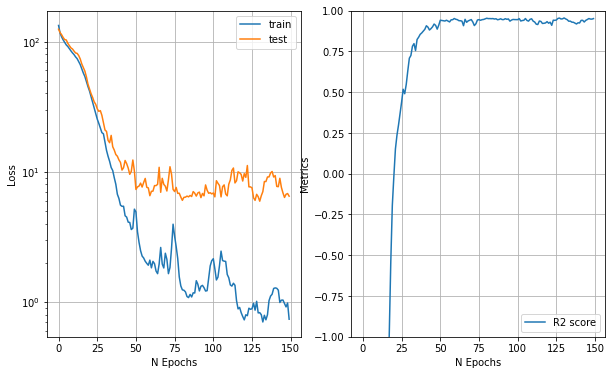

Loss on validation : 6.498027448964895 

R2 score : 0.9511514027557386  



ValueError: too many values to unpack (expected 2)

In [147]:
model, lm1, lm2 = train_multitask(model, optimizer, train_dataloader, test_dataloader,
                            len(train_dataset), len(test_dataset),
                            Loss1, Loss2, metric_dict1, metric_dict2, N_epochs = 150)